In [1]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as c
from astropy.table import Table
import numpy as np
from matplotlib import colors
import lmfit
import glob
from lmfit.models import GaussianModel, SplineModel, PolynomialModel
import pandas as pd
from astropy.io import ascii

In [2]:
def vac_to_air(wavelength):
    """
    Griesen 2006 reports that the error in naively inverting Eqn 65 is less
    than 10^-9 and therefore acceptable.  This is therefore eqn 67
    """
    wlum = wavelength.to(u.um).value
    nl = (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4))
    return wavelength/nl

In [3]:
def plot_data(obj,percentile = [1, 99],use_log = False):
    if(use_log):
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])),norm=colors.LogNorm())
    else:
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])))
    plt.colorbar()

def read_file(file_name):
    return np.flip(fits.open(file_name)['PRIMARY'].data.astype(float), axis = 1)

In [4]:
files = glob.glob("./20230507/*.fits")
files = np.sort(files)

In [5]:
slit_w = 30 * u.arcsecond
scale = 0.37 * u.arcsecond
slit_pixel_w = int(slit_w / scale) + 20
slit_pixel_w

101

In [6]:
print(repr(fits.open(files[70])[0].header))

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2048 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
OBJECT  = 'ATO     '           / object name                                    
SOFTVER = '4.0     '           / software version                               
HDR_REV = '4.3     '        

In [7]:
Obslog = Table(
                    names=("File", "Date", "UTC", "ra", "dec", "observer", "objid", "airmass", "exptime", "obstype"
                    ),
                    meta={"name": "Observation Log"},
                    dtype=("U64", "U64", "U64", "U64", "U64", "U64", "U64", "float64", "float64", "U64"
                          )
                    )
for i in files:
      open_file = fits.open(i)
      header_file = open_file[0].header
      row = [i, header_file["DATE"], header_file["TIME"], header_file["RA"],
             header_file["DEC"], header_file["OBSERVER"], header_file["OBJECT"], 
             header_file["AIRMASS"], header_file["EXPTIME"], header_file["OBSTYPE"]]
      Obslog.add_row(row)
Obslog

File,Date,UTC,ra,dec,observer,objid,airmass,exptime,obstype
str64,str64,str64,str64,str64,str64,str64,float64,float64,str64
./20230507\image0001.fits,126,23:32:08.2,06:41:18.93,+33:31:29.1,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0002.fits,126,23:33:31.8,06:42:42.78,+33:31:31.9,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0003.fits,126,23:34:19.6,06:43:30.72,+33:31:33.4,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0004.fits,126,23:35:08.4,06:44:19.66,+33:31:35.0,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0005.fits,126,23:35:57.2,06:45:08.59,+33:31:36.6,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0006.fits,126,23:36:46.0,06:45:57.55,+33:31:38.2,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0007.fits,126,23:37:34.9,06:46:46.58,+33:31:39.8,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0008.fits,126,23:38:23.7,06:47:35.53,+33:31:41.4,xanderberylcarlos,lampon,1.0,45.0,flat
./20230507\image0009.fits,126,23:39:12.5,06:48:24.46,+33:31:43.0,xanderberylcarlos,lampon,1.0,45.0,flat


In [8]:
xb_data = Obslog[np.where("xanderberyl" == Obslog["observer"])]
flat_table = Obslog[np.where("flat" == Obslog["obstype"])]
standard = Obslog[np.where("HD 162208" == Obslog["objid"])]

In [9]:
flat_table_on = flat_table[np.where("lampon" == flat_table["objid"])]
flat_table_off = flat_table[np.where("lampoff" == flat_table["objid"])]

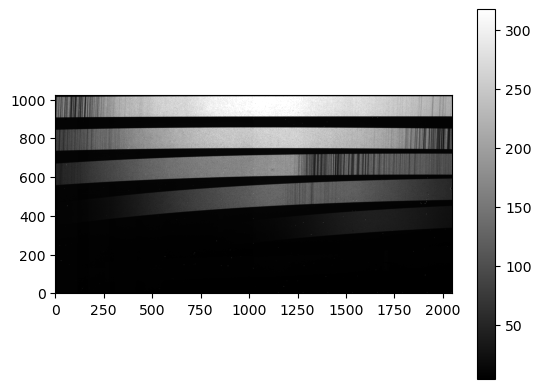

In [10]:
flat_data_on = []
for i in flat_table_on:
    flat_data_on.append((read_file(i["File"])) / i["exptime"])
flat_data_on = np.median(np.asarray(flat_data_on), axis=0)
flat_on = flat_data_on
plot_data(flat_on)

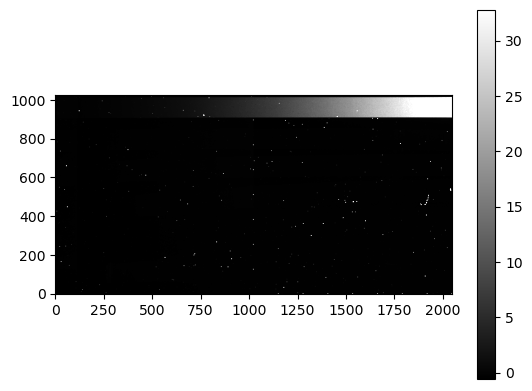

In [11]:
flat_data_off = []
for i in flat_table_off:
    flat_data_off.append((read_file(i["File"])) / i["exptime"])
flat_data_off = np.median(np.asarray(flat_data_off), axis=0)
flat_off = flat_data_off
plot_data(flat_off)

In [12]:
def find_cutoffs(x, minimum = 0.04):
    signal = np.where(x > minimum)[0]
    l_r = [signal[0]]
    for i in range(1 , len(signal)):
        prev_index = signal[i - 1]
        curr_index = signal[i]
        if((curr_index - prev_index) > 5):
            l_r.append(prev_index)
            l_r.append(curr_index)
    l_r.append(signal[-1])
    return l_r


1.0


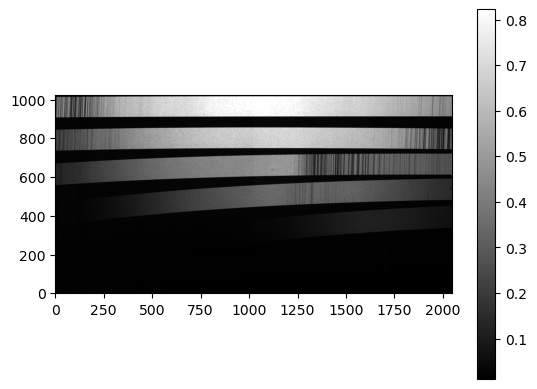

In [13]:
flat_counts = flat_on - flat_off
#flat = flat_counts / np.percentile(flat_counts, 99)
flat = flat_counts / np.max(flat_counts)
print(np.max(flat))
plot_data(flat)
plt.show()

In [14]:
def read_file_flat(file_name, f = flat):
    return np.flip(fits.open(file_name)['PRIMARY'].data.astype(float), axis = 1)/f

In [15]:
flat.shape[1]

2048

In [16]:
cutoffs = []
for i in range(flat.shape[1]):
    cutoffs.append(find_cutoffs(flat[:,i]))
cutoffs = np.array(cutoffs)
cutoffs.shape

C:\Users\20xha\AppData\Local\Temp\ipykernel_26952\4224830578.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cutoffs = np.array(cutoffs)


(2048,)

In [17]:
twoam_std = standard[0:4]
threethrityam_std = standard[4:8]
fiveam_std = standard[8:12]

In [18]:
trace = Table.from_pandas(pd.read_csv("tspec_traces.csv"))
trace["order3_min"] = np.floor(trace["order3"] - slit_pixel_w/2).astype(int)
trace["order3_max"] = np.ceil(trace["order3"] + slit_pixel_w/2).astype(int)

In [19]:
def rectify(data, trace, slit_w, order, offset = 0):
    trace_line_min = np.floor(trace[order] - slit_w/2).astype(int) 
    trace_line_max = trace_line_min + slit_w + offset
    rectangle = []
    for i in range(data.shape[1]):
        column = data[:,i]
        rectangle.append(column[trace_line_min[i]:trace_line_max[i]])
    rectangle = np.asarray(rectangle)
    return rectangle.T

In [20]:
slit_pixel_w

101

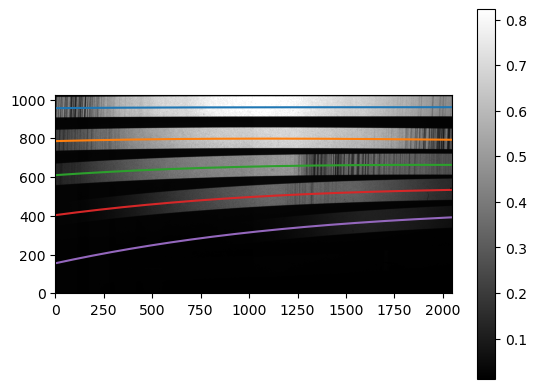

In [21]:
plot_data(flat)
plt.plot(range(2048), trace["order3"])
plt.plot(range(2048), trace["order4"])
plt.plot(range(2048), trace["order5"])
plt.plot(range(2048), trace["order6"])
plt.plot(range(2048), trace["order7"])

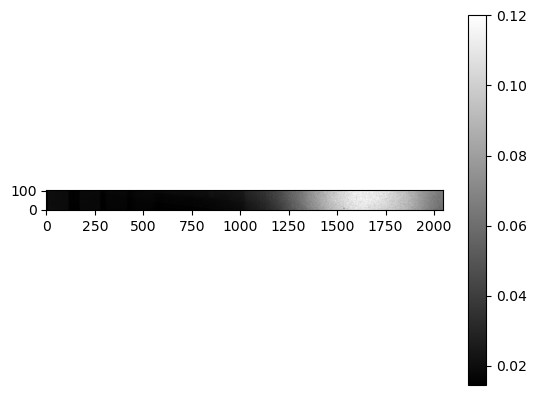

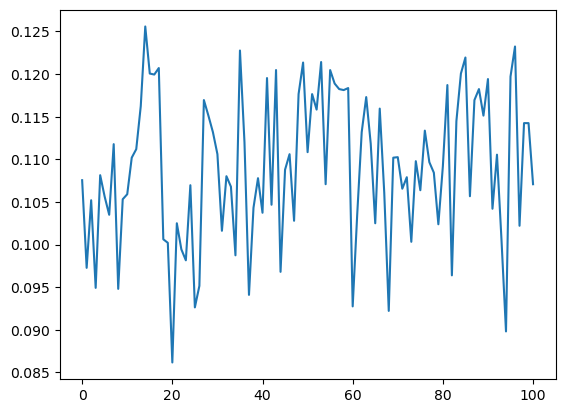

In [22]:
flat_rectify_order_3 = rectify(flat, trace, slit_pixel_w, "order7")
plot_data(flat_rectify_order_3)
plt.show()
plt.plot(flat_rectify_order_3[:,1600])

In [23]:
def norm(data, flat):
    return data/flat

In [24]:
def AB_sub_flat(A, B, f = flat):
    return (A - B)/f

In [25]:
def ABBA_sub_flat(data, f = flat):
    return ((data[0] - data[1]) + (data[3] - data[2]))/f

In [26]:
def ABBA_sub_flat_i(data, f = flat):
    return ((data[1] - data[0]) + (data[2] - data[3]))/f

In [27]:
def ABBA_sub(data):
    return ((data[0] - data[1]) + (data[3] - data[2]))

In [28]:
def AB_sub(A, B):
    return (A - B)

In [29]:
twoam_std_data = []
for i in twoam_std:
    twoam_std_data.append((read_file(i["File"]) / i["exptime"]))
twoam_std_data = np.array(twoam_std_data)


C:\Users\20xha\AppData\Local\Temp\ipykernel_26952\2672243274.py:2: RuntimeWarning: divide by zero encountered in divide
  return (A - B)/f


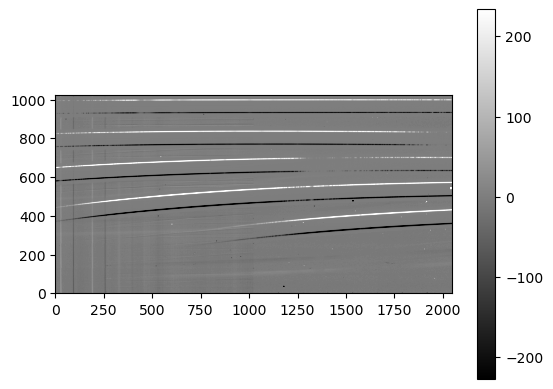

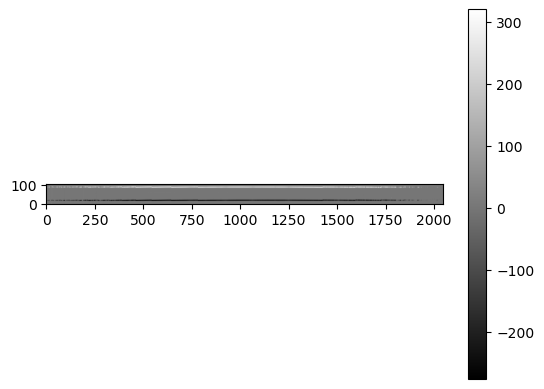

In [30]:
twoam_ab_data = AB_sub_flat(twoam_std_data[0], twoam_std_data[1])
plot_data(twoam_ab_data)
plt.show()
twoam_ab_data_7 = rectify(twoam_ab_data, trace, slit_pixel_w, "order4")
plot_data(twoam_ab_data_7)

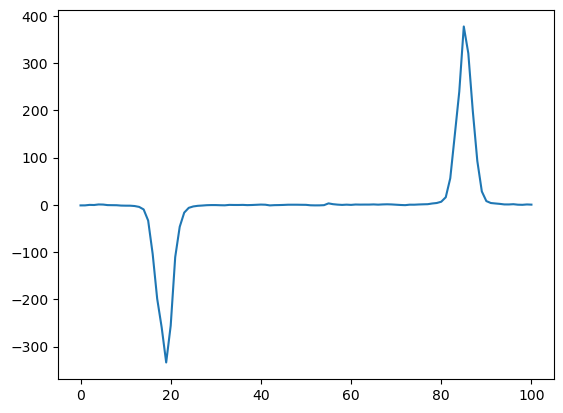

In [31]:
plt.plot(twoam_ab_data_7[:,1000])

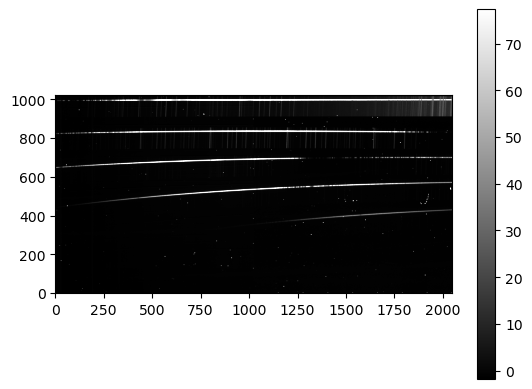

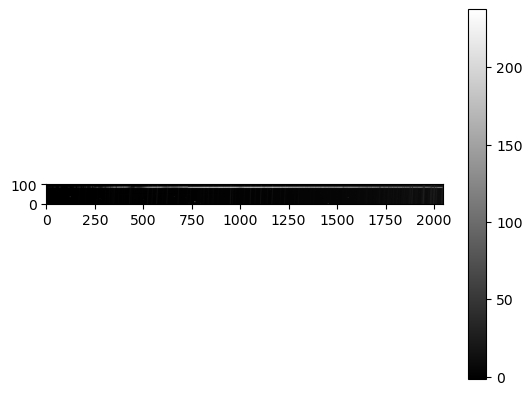

In [32]:
plot_data(twoam_std_data[0])
plt.show()
A_3 = rectify(twoam_std_data[0], trace, slit_pixel_w, "order3")
plot_data(A_3)

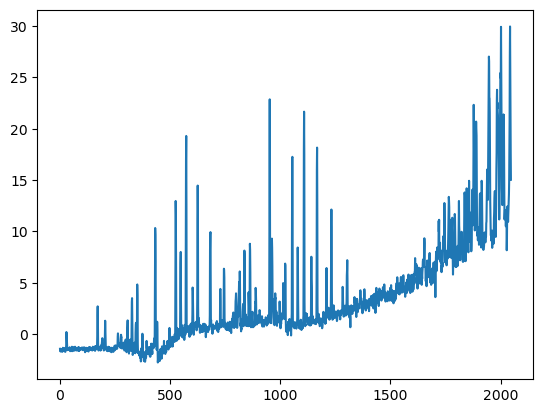

In [33]:
plt.plot(A_3[50])
#plt.yscale("log")

In [34]:
np.unique(Obslog["objid"])

ATO
B
B eclipse
FS64
FS80
HD
HD 162208
RS Oph
StKM 1-1155
TYC
arc


In [35]:
not_obs = Obslog[np.where("B" == Obslog["objid"])]
not_obs1 = not_obs[0:4]
not_obs2 = not_obs[4:8]
not_obs

File,Date,UTC,ra,dec,observer,objid,airmass,exptime,obstype
str64,str64,str64,str64,str64,str64,str64,float64,float64,str64
./20230507\image0033.fits,127,08:34:32.3,18:31:16.23,+26:55:52.6,xanderberyl,B,1.237,300.0,object
./20230507\image0034.fits,127,08:40:09.6,18:31:17.54,+26:55:53.0,xanderberyl,B,1.219,300.0,object
./20230507\image0035.fits,127,08:45:45.6,18:31:17.53,+26:55:53.5,xanderberyl,B,1.202,300.0,object
./20230507\image0036.fits,127,08:51:23.7,18:31:16.23,+26:55:53.9,xanderberyl,B,1.186,300.0,object
./20230507\image0095.fits,127,11:33:55.0,18:31:16.31,+26:55:56.2,xanderberyl,B,1.008,300.0,object
./20230507\image0096.fits,127,11:39:33.5,18:31:17.60,+26:55:56.5,xanderberyl,B,1.009,300.0,object
./20230507\image0097.fits,127,11:45:09.6,18:31:17.59,+26:55:56.4,xanderberyl,B,1.011,300.0,object
./20230507\image0098.fits,127,11:50:47.6,18:31:16.32,+26:55:56.6,xanderberyl,B,1.013,300.0,object


In [36]:
t_obs = Obslog[np.where("B eclipse" == Obslog["objid"])]
t_obs1 = not_obs[0:4]
t_obs2 = not_obs[4:8]
t_obs

File,Date,UTC,ra,dec,observer,objid,airmass,exptime,obstype
str64,str64,str64,str64,str64,str64,str64,float64,float64,str64
./20230507\image0055.fits,127,09:35:13.5,18:31:16.24,+26:55:56.1,xanderberyl,B eclipse,1.09,300.0,object
./20230507\image0056.fits,127,09:40:51.7,18:31:17.54,+26:55:56.1,xanderberyl,B eclipse,1.08,300.0,object
./20230507\image0057.fits,127,09:46:27.0,18:31:17.56,+26:55:56.0,xanderberyl,B eclipse,1.072,300.0,object
./20230507\image0058.fits,127,09:52:05.8,18:31:16.25,+26:55:56.0,xanderberyl,B eclipse,1.064,300.0,object
./20230507\image0059.fits,127,09:57:49.9,18:31:16.18,+26:55:56.1,xanderberyl,B eclipse,1.056,300.0,object
./20230507\image0060.fits,127,10:03:27.7,18:31:17.43,+26:55:56.2,xanderberyl,B eclipse,1.049,300.0,object
./20230507\image0061.fits,127,10:09:03.6,18:31:17.45,+26:55:55.9,xanderberyl,B eclipse,1.043,300.0,object
./20230507\image0062.fits,127,10:14:41.7,18:31:16.15,+26:55:56.2,xanderberyl,B eclipse,1.037,300.0,object


In [37]:
def read_ABBA(table):
    data = []
    for i in table:
        data.append((read_file(i["File"]) / i["exptime"]))
    return np.array(data)

In [38]:
B2 = read_ABBA(not_obs2)

C:\Users\20xha\AppData\Local\Temp\ipykernel_26952\121415347.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((data[1] - data[0]) + (data[2] - data[3]))/f


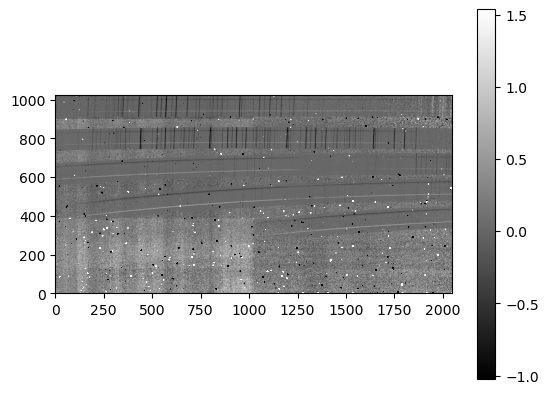

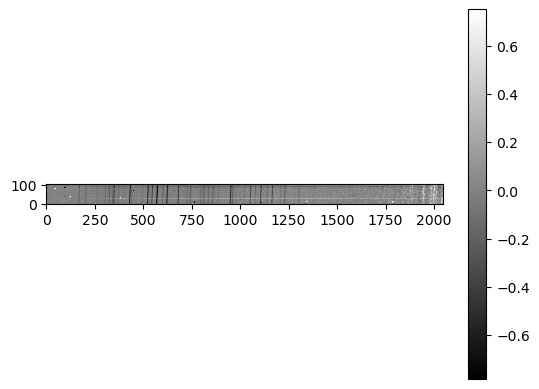

In [39]:
B2_reduced = ABBA_sub_flat_i(B2)
plot_data(B2_reduced)
plt.show()
B2_reduced_order3 = rectify(B2_reduced, trace, slit_pixel_w, "order3")
plot_data(B2_reduced_order3)
plt.show()

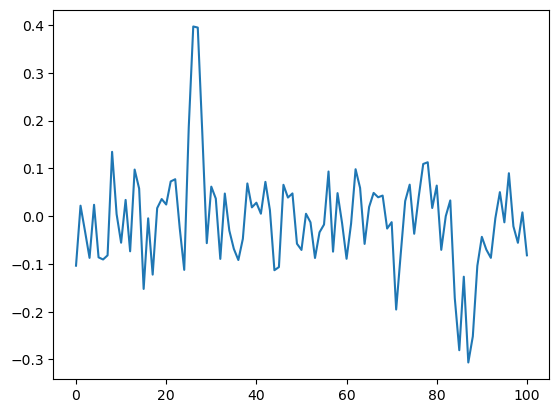

In [40]:
plt.plot(B2_reduced_order3[:,750])

C:\Users\20xha\AppData\Local\Temp\ipykernel_26952\121415347.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((data[1] - data[0]) + (data[2] - data[3]))/f


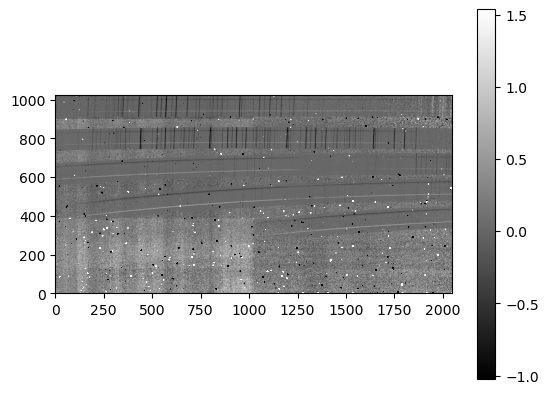

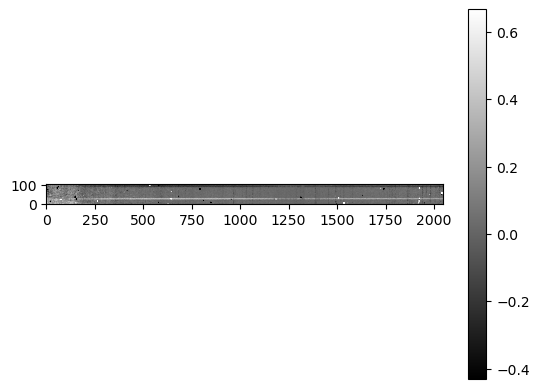

In [41]:
B1 = read_ABBA(not_obs2)
B1_reduced = ABBA_sub_flat_i(B1)
plot_data(B1_reduced)
plt.show()
B1_reduced_order4 = rectify(B1_reduced, trace, slit_pixel_w, "order6")
plot_data(B1_reduced_order4)

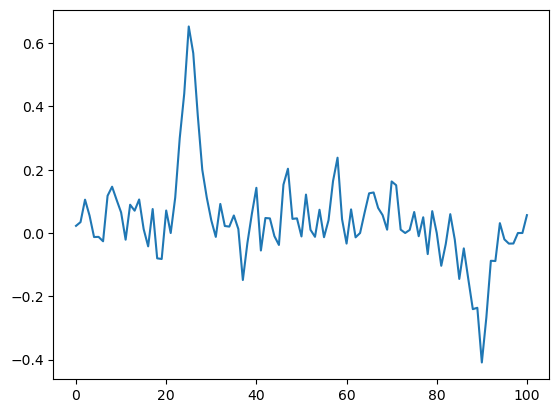

In [42]:
plt.plot(B1_reduced_order4[:,1000])

C:\Users\20xha\AppData\Local\Temp\ipykernel_26952\996342939.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((data[0] - data[1]) + (data[3] - data[2]))/f


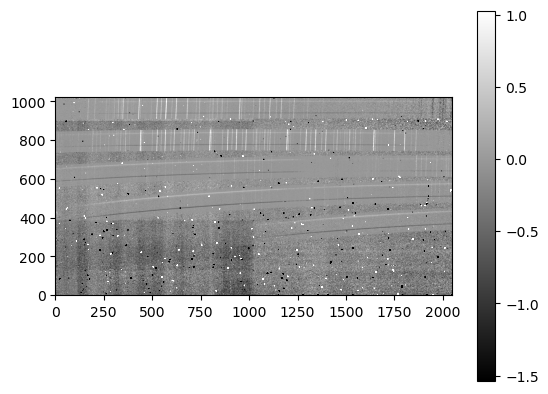

In [43]:
plot_data(ABBA_sub_flat(B2))
plt.show()

C:\Users\20xha\AppData\Local\Temp\ipykernel_26952\996342939.py:2: RuntimeWarning: divide by zero encountered in divide
  return ((data[0] - data[1]) + (data[3] - data[2]))/f


File,Date,UTC,ra,dec,observer,objid,airmass,exptime,obstype
str64,str64,str64,str64,str64,str64,str64,float64,float64,str64
./20230507\image0095.fits,127,11:33:55.0,18:31:16.31,+26:55:56.2,xanderberyl,B,1.008,300.0,object
./20230507\image0096.fits,127,11:39:33.5,18:31:17.60,+26:55:56.5,xanderberyl,B,1.009,300.0,object
./20230507\image0097.fits,127,11:45:09.6,18:31:17.59,+26:55:56.4,xanderberyl,B,1.011,300.0,object
./20230507\image0098.fits,127,11:50:47.6,18:31:16.32,+26:55:56.6,xanderberyl,B,1.013,300.0,object


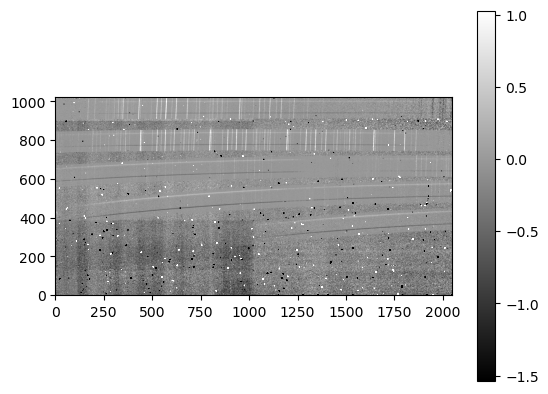

In [44]:
tB2 = read_ABBA(t_obs2)
tB2_reduced = ABBA_sub_flat(tB2)
plot_data(tB2_reduced)
t_obs2

C:\Users\20xha\AppData\Local\Temp\ipykernel_26952\3780475559.py:1: RuntimeWarning: divide by zero encountered in divide
  sky_lines = B1[0]/flat


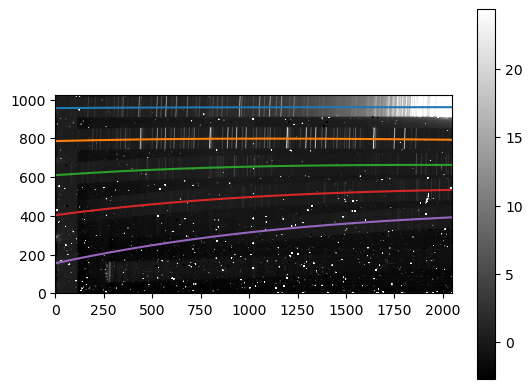

In [267]:
sky_lines = B1[0]/flat
plot_data(sky_lines)
sky_order3 = np.median(rectify(sky_lines, trace, slit_pixel_w, "order3")[40:60], axis = 0)
sky_order4 = np.median(rectify(sky_lines, trace, slit_pixel_w, "order4")[40:60], axis = 0)
sky_order5 = np.median(rectify(sky_lines, trace, slit_pixel_w, "order5")[40:60], axis = 0)
sky_order6 = np.median(rectify(sky_lines, trace, slit_pixel_w, "order6")[40:60], axis = 0)
sky_order7 = np.median(rectify(sky_lines, trace, slit_pixel_w, "order7")[40:60], axis = 0)

plt.plot(range(2048), trace["order3"])
plt.plot(range(2048), trace["order4"])
plt.plot(range(2048), trace["order5"])
plt.plot(range(2048), trace["order6"])
plt.plot(range(2048), trace["order7"])

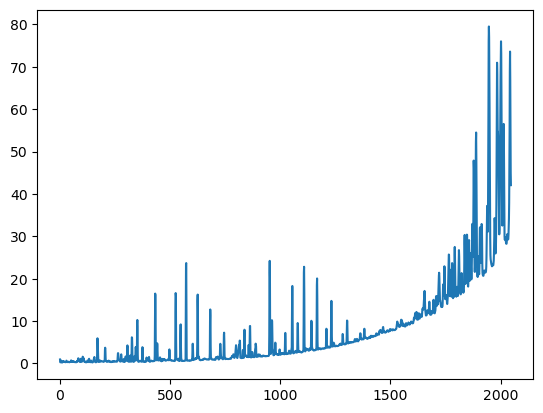

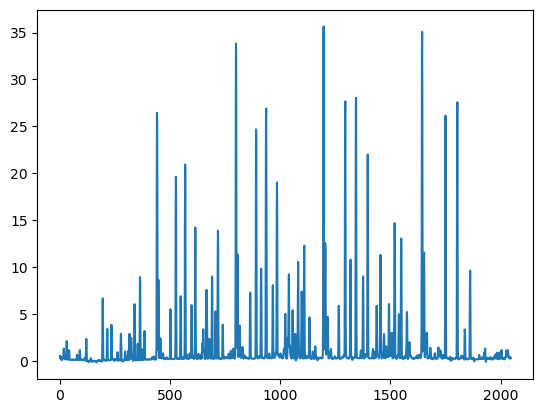

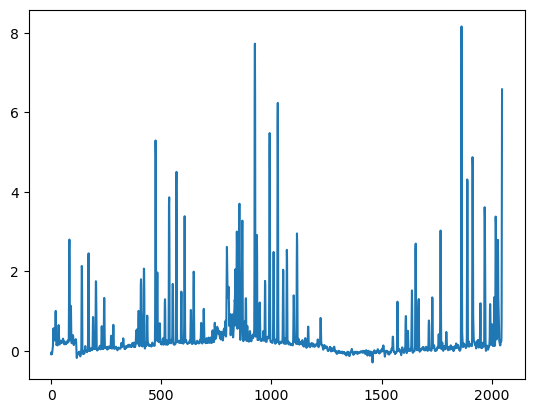

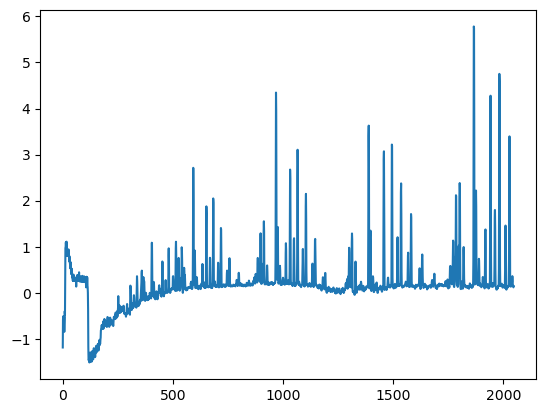

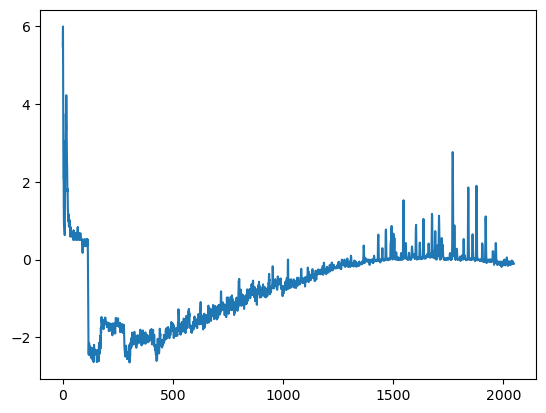

In [46]:
plt.plot(sky_order3)
plt.show()
plt.plot(sky_order4)
plt.show()
plt.plot(sky_order5)
plt.show()
plt.plot(sky_order6)
plt.show()
plt.plot(sky_order7)
plt.show()


In [47]:
order3_r = [2.4644498, 1.8760142] * u.micron
order4_r = [1.8501315, 1.4103792] * u.micron
order5_r = [1.4835071, 1.1297587] * u.micron
order6_r = [1.2379470, 0.94296033] * u.micron
order7_r = [1.0629230, 0.80778160] * u.micron
pixel_w_count = sky_lines.shape[1]
order3_l = np.linspace(order3_r[1], order3_r[0], pixel_w_count)
order4_l = np.linspace(order4_r[1], order4_r[0], pixel_w_count)
order5_l = np.linspace(order5_r[1], order5_r[0], pixel_w_count)
order6_l = np.linspace(order6_r[1], order6_r[0], pixel_w_count)
order7_l = np.linspace(order7_r[1], order7_r[0], pixel_w_count)

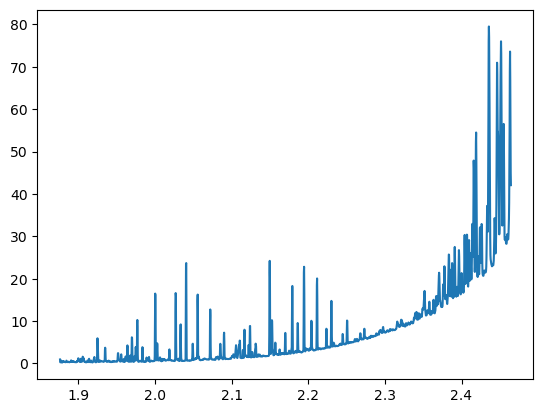

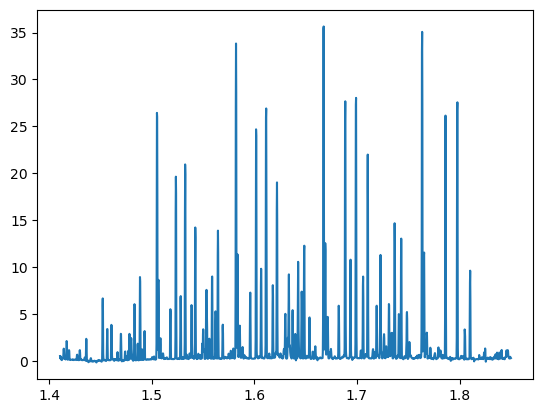

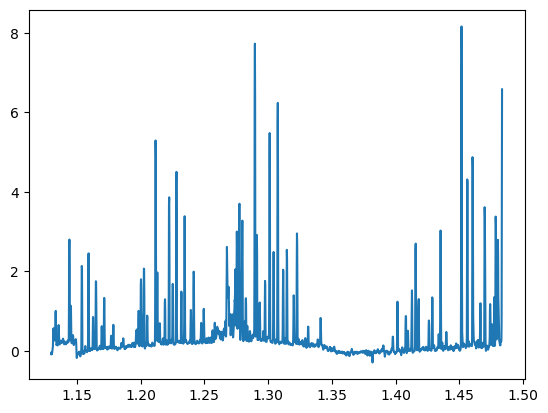

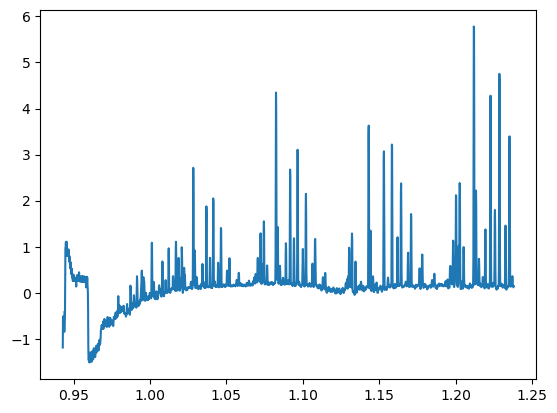

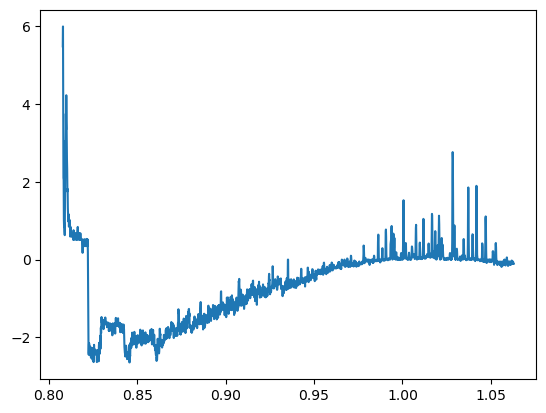

In [48]:
plt.plot(order3_l, sky_order3)
plt.show()
plt.plot(order4_l, sky_order4)
plt.show()
plt.plot(order5_l, sky_order5)
plt.show()
plt.plot(order6_l, sky_order6)
plt.show()
plt.plot(order7_l, sky_order7)
plt.show()

In [49]:
nearir_lines = ascii.read("nearir/rousselot2000.dat")
nearir_lines.rename_column("col1", "Wavelength_vac")
nearir_lines.rename_column("col2", "Flux")
nearir_lines["Wavelength_vac"].unit = u.angstrom
nearir_lines["Wavelength_vac"] = nearir_lines["Wavelength_vac"].to(u.micron)
nearir_lines["Wavelength_air"] = vac_to_air(nearir_lines["Wavelength_vac"])
nearir_lines[0]


Wavelength_vac,Flux,Wavelength_air
micron,,micron
float64,float64,float64
0.6138239000000001,0.1258,0.6136446946183212


In [185]:
box = 30 * u.AA
box = box.to(u.micron)
order = order3_r
wavelengths = order3_l
counts = sky_order3
pixel_n = np.arange(sky_order3.shape[0])

In [255]:
def wavelength_solution(order, wavelengths, counts, box = 30 * u.AA, flux_limit = 1, plot_no = False):
    box = box.to(u.micron)
    lines_in_order = nearir_lines[np.where((nearir_lines["Wavelength_air"] > order[1]) & (nearir_lines["Wavelength_air"] < order[0]) & (nearir_lines["Flux"] > flux_limit))[0]]
    pixel_array = []

    for i in lines_in_order:
        specific_line = np.where((wavelengths > i["Wavelength_air"] * u.micron - box) & (wavelengths < i["Wavelength_air"] * u.micron + box))[0]
        max_position = np.argmax(counts[specific_line])
        pixel_array.append([specific_line[max_position], i["Wavelength_air"]])
        correct_position = wavelengths[specific_line][max_position]
        space_plot = np.where((wavelengths > i["Wavelength_air"] * u.micron - box * 10) & (wavelengths < i["Wavelength_air"] * u.micron + box * 10))[0]
        if(plot_no):
            plt.plot(wavelengths[space_plot], counts[space_plot])
            plt.vlines(i["Wavelength_air"], np.min(counts[space_plot]), np.max(counts[space_plot]), color = "red")
            plt.vlines(correct_position.value, np.min(counts[space_plot]), np.max(counts[space_plot]), color = "g")
            plt.title(i["Wavelength_air"])
            plt.savefig("order3_line_solution/" + str(i["Wavelength_air"]) + ".png")
            plt.close()
    pixel_array = np.asarray(pixel_array)

    l_model = PolynomialModel(degree = 3)
    l_params = l_model.guess(pixel_array[:,1], x = pixel_array[:,0])
    l_result = l_model.fit(pixel_array[:,1], l_params, x = pixel_array[:,0])
    wavelengths_model = l_model.eval(l_params, x = range(0,wavelengths.shape[0]))
    t = Table()
    t["wavelengths"] = wavelengths_model
    t["wavelengths"].unit = u.micron
    t["counts"] = counts
    return t

In [260]:
order3 = wavelength_solution(order3_r, order3_l, sky_order3)
order4 = wavelength_solution(order4_r, order4_l, sky_order4)
order5 = wavelength_solution(order5_r, order5_l, sky_order5)
order6 = wavelength_solution(order6_r, order6_l, sky_order6)
order7 = wavelength_solution(order7_r, order7_l, sky_order7)

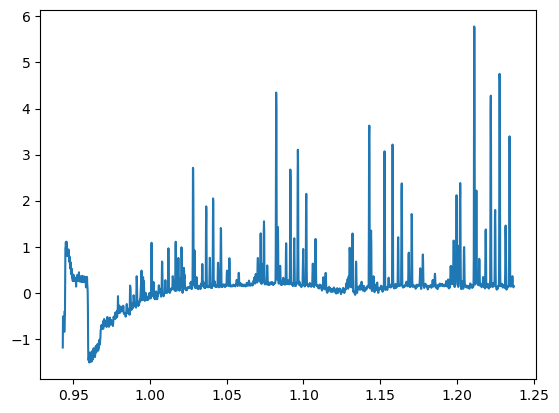

In [265]:
plt.plot(order6["wavelengths"], order6["counts"])

In [240]:
lines_in_order = nearir_lines[np.where((nearir_lines["Wavelength_air"] > order3_r[1]) & (nearir_lines["Wavelength_air"] < order3_r[0]) & (nearir_lines["Flux"] > 1))[0]]
len(lines_in_order)

238

In [241]:
np.median(lines_in_order["Flux"])

83.81

In [242]:
i = lines_in_order[-1]
i

Wavelength_vac,Flux,Wavelength_air
micron,,micron
float64,float64,float64
2.3537791000000006,1.726,2.353101618634683


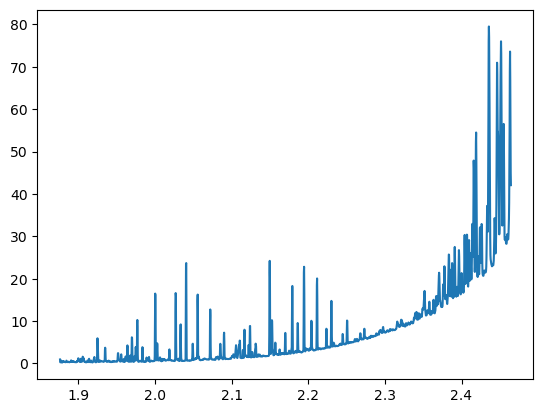

In [239]:
plt.plot(wavelengths, counts)

In [243]:
specific_line = np.where((wavelengths > i["Wavelength_air"] * u.micron - box) & (wavelengths < i["Wavelength_air"] * u.micron + box))[0]

#model = GaussianModel()
#params = model.guess(counts[specific_line], x = wavelengths[specific_line].value)
#result = model.fit(counts[specific_line], params, x = wavelengths[specific_line].value)

correct_position = wavelengths[specific_line][np.argmax(counts[specific_line])]
further_w = 8
space_plot = np.where((wavelengths > i["Wavelength_air"] * u.micron - box * further_w) & (wavelengths < i["Wavelength_air"] * u.micron + box * further_w))[0]

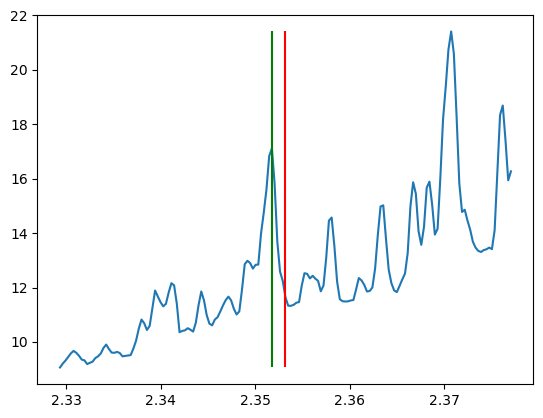

In [244]:
plt.plot(wavelengths[space_plot], counts[space_plot])
plt.vlines(i["Wavelength_air"], np.min(counts[space_plot]), np.max(counts[space_plot]), color = "red")
plt.vlines(correct_position.value, np.min(counts[space_plot]), np.max(counts[space_plot]), color = "g")

In [245]:
params["center"].value

1.8760142

In [246]:
wavelengths[specific_line][np.argmax(counts[specific_line])]

<Quantity 2.35176453 micron>

In [247]:
result.params["center"].value

1.821180413036471

In [250]:
plot_no = False
pixel_array = []
for i in lines_in_order:
    specific_line = np.where((wavelengths > i["Wavelength_air"] * u.micron - box) & (wavelengths < i["Wavelength_air"] * u.micron + box))[0]
    max_position = np.argmax(counts[specific_line])
    pixel_array.append([specific_line[max_position], i["Wavelength_air"]])
    correct_position = wavelengths[specific_line][max_position]
    space_plot = np.where((wavelengths > i["Wavelength_air"] * u.micron - box * 10) & (wavelengths < i["Wavelength_air"] * u.micron + box * 10))[0]
    if(plot_no):
        plt.plot(wavelengths[space_plot], counts[space_plot])
        plt.vlines(i["Wavelength_air"], np.min(counts[space_plot]), np.max(counts[space_plot]), color = "red")
        plt.vlines(correct_position.value, np.min(counts[space_plot]), np.max(counts[space_plot]), color = "g")
        plt.title(i["Wavelength_air"])
        plt.savefig("order3_line_solution/" + str(i["Wavelength_air"]) + ".png")
        plt.close()
pixel_array = np.asarray(pixel_array)

In [251]:
l_model = PolynomialModel(degree = 3)
l_params = l_model.guess(pixel_array[:,1], x = pixel_array[:,0])
l_result = l_model.fit(pixel_array[:,1], l_params, x = pixel_array[:,0])
wavelenths_model = l_model.eval(l_params, x = range(0,wavelengths.shape[0]))

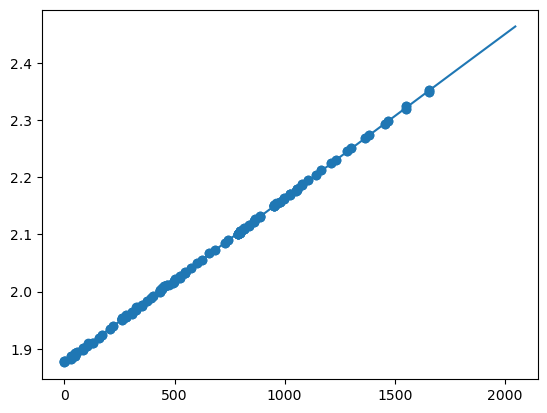

In [252]:
plt.plot(range(0,wavelengths.shape[0]), wavelenths_model)
plt.scatter(pixel_array[:,0], pixel_array[:,1])

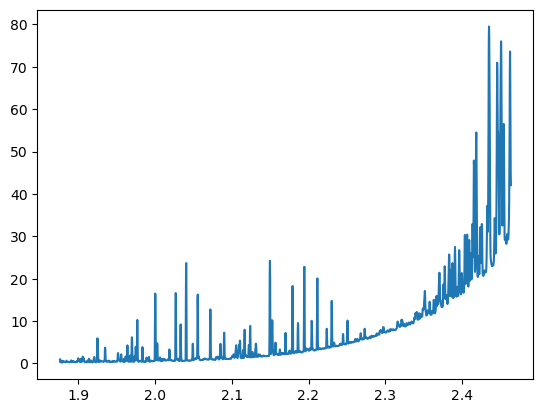

In [253]:
plt.plot(wavelenths_model, counts)

In [257]:
wavelenths_model

array([1.87617674, 1.87646333, 1.87674993, ..., 2.46319939, 2.46348473,
       2.46377007])